### Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
import importlib
from torch_lr_finder import LRFinder
from utils import utils
from utils.utils import fabric
from utils.dataset import Dataset
from utils.scheduler import Scheduler
import warnings

warnings.filterwarnings('ignore')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [2]:
# Initialize
utils.set_seed(1)

### Import dataset: CIFAR10

In [3]:
batch_size = 512
dataset = Dataset('CIFAR10', batch_size=batch_size, trans_lib='albumentations')

# Add augmentations for training dataset
dataset.dt.set_transforms('train', [
    A.HorizontalFlip(),
    A.PadIfNeeded(min_height=40, min_width=40),
    A.RandomCrop(height=32, width=32),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, fill_value=dataset.dt.mean)
], True)

Files already downloaded and verified
Files already downloaded and verified
The mean and SD for CIFAR10 dataset are [0.49139968 0.48215841 0.44653091] and [0.24703223 0.24348513 0.26158784] respectively.
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader, test_loader = dataset.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

### Visualize input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


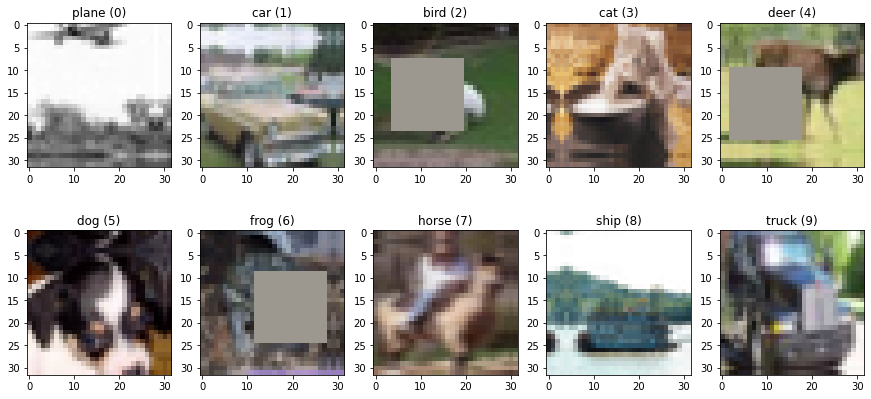

In [6]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, label_mapper, n_cols=5, figsize=(15, 7))

### Model Training

In [7]:
from models import resnet
importlib.reload(resnet)

<module 'models.resnet' from 'd:\\Self Learning\\TSAI\\TSAI\\S11\\models\\resnet.py'>

In [8]:
from models.resnet import ResNet18
device = utils.get_device()
model = ResNet18().to(device)
model.print_summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [512, 10]                 --
├─Conv2d: 1-1                            [512, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [512, 64, 32, 32]         128
├─Sequential: 1-3                        [512, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [512, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [512, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [512, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [512, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [512, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [512, 64, 32, 32]         --
│    └─BasicBlock: 2-2                   [512, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [512, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [512, 64, 32, 32]         

### LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-02


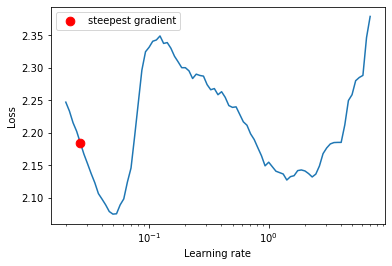

Max LR suggsted by LRFinder is 0.02656087782946686


In [9]:
model = ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")
_, max_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

print(f'Max LR suggsted by LRFinder is {max_lr}')

In [10]:
num_epochs = 20
steps_per_epoch = len(train_loader)

scheduler = Scheduler('OneCycleLR', {
    'optimizer': optimizer,
    'max_lr': max_lr,
    'steps_per_epoch': steps_per_epoch, 
    'epochs': num_epochs, 
    'pct_start': 5/num_epochs,
    'div_factor': 100,
    'final_div_factor': 100,
    'three_phase': False,
    'anneal_strategy': 'linear',
    'verbose': False
})

for epoch in range(1, num_epochs+1):
    print('EPOCH:', epoch)
    model.model_train(device, train_loader, criterion, optimizer, scheduler)
    model.model_test(device, test_loader, criterion)

EPOCH: 1


Train: Loss=1.5815, LR=0.00553541729979748, Accuracy=30.98: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]  


Test: Average Loss: 1.7602, Accuracy: 3909/10000 (39.09%), Accuracy Diff: 8.114

EPOCH: 2


Train: Loss=1.2260, LR=0.010805225821300292, Accuracy=50.38: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s] 


Test: Average Loss: 1.5853, Accuracy: 4871/10000 (48.71%), Accuracy Diff: 1.67

EPOCH: 3


Train: Loss=0.9920, LR=0.0160750343428031, Accuracy=59.84: 100%|██████████| 98/98 [01:28<00:00,  1.10it/s]  


Test: Average Loss: 1.2644, Accuracy: 5727/10000 (57.27%), Accuracy Diff: 2.572

EPOCH: 4


Train: Loss=0.8062, LR=0.021344842864305914, Accuracy=65.51: 100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Test: Average Loss: 0.8962, Accuracy: 7060/10000 (70.60%), Accuracy Diff: 5.09

EPOCH: 5


Train: Loss=0.8833, LR=0.02654281101195551, Accuracy=69.99: 100%|██████████| 98/98 [01:32<00:00,  1.06it/s]  


Test: Average Loss: 0.7332, Accuracy: 7533/10000 (75.33%), Accuracy Diff: 5.338

EPOCH: 6


Train: Loss=0.7759, LR=0.02477226289584325, Accuracy=73.64: 100%|██████████| 98/98 [01:27<00:00,  1.13it/s] 


Test: Average Loss: 0.7356, Accuracy: 7574/10000 (75.74%), Accuracy Diff: 2.102

EPOCH: 7


Train: Loss=0.6946, LR=0.023001714779730988, Accuracy=75.80: 100%|██████████| 98/98 [01:18<00:00,  1.25it/s]


Test: Average Loss: 0.5919, Accuracy: 8012/10000 (80.12%), Accuracy Diff: 4.322

EPOCH: 8


Train: Loss=0.6620, LR=0.02123116666361873, Accuracy=77.59: 100%|██████████| 98/98 [01:18<00:00,  1.25it/s] 


Test: Average Loss: 0.7635, Accuracy: 7564/10000 (75.64%), Accuracy Diff: 1.952

EPOCH: 9


Train: Loss=0.5766, LR=0.019460618547506466, Accuracy=79.06: 100%|██████████| 98/98 [01:21<00:00,  1.21it/s]


Test: Average Loss: 0.6076, Accuracy: 8026/10000 (80.26%), Accuracy Diff: 1.198

EPOCH: 10


Train: Loss=0.5168, LR=0.017690070431394207, Accuracy=80.64: 100%|██████████| 98/98 [01:21<00:00,  1.20it/s]


Test: Average Loss: 0.6316, Accuracy: 7987/10000 (79.87%), Accuracy Diff: 0.77

EPOCH: 11


Train: Loss=0.5717, LR=0.015919522315281945, Accuracy=81.76: 100%|██████████| 98/98 [01:18<00:00,  1.25it/s]


Test: Average Loss: 0.5749, Accuracy: 8134/10000 (81.34%), Accuracy Diff: 0.418

EPOCH: 12


Train: Loss=0.5003, LR=0.014148974199169684, Accuracy=82.47: 100%|██████████| 98/98 [01:18<00:00,  1.25it/s]


Test: Average Loss: 0.4606, Accuracy: 8453/10000 (84.53%), Accuracy Diff: 2.062

EPOCH: 13


Train: Loss=0.4408, LR=0.012378426083057423, Accuracy=83.48: 100%|██████████| 98/98 [01:18<00:00,  1.24it/s]


Test: Average Loss: 0.4837, Accuracy: 8448/10000 (84.48%), Accuracy Diff: 1.002

EPOCH: 14


Train: Loss=0.4012, LR=0.010607877966945161, Accuracy=84.43: 100%|██████████| 98/98 [01:18<00:00,  1.25it/s]


Test: Average Loss: 0.4421, Accuracy: 8568/10000 (85.68%), Accuracy Diff: 1.25

EPOCH: 15


Train: Loss=0.4019, LR=0.008837329850832902, Accuracy=85.20: 100%|██████████| 98/98 [01:16<00:00,  1.27it/s]


Test: Average Loss: 0.3946, Accuracy: 8725/10000 (87.25%), Accuracy Diff: 2.052

EPOCH: 16


Train: Loss=0.3335, LR=0.007066781734720643, Accuracy=86.14: 100%|██████████| 98/98 [01:15<00:00,  1.30it/s] 


Test: Average Loss: 0.4504, Accuracy: 8570/10000 (85.70%), Accuracy Diff: 0.44

EPOCH: 17


Train: Loss=0.3775, LR=0.005296233618608381, Accuracy=87.03: 100%|██████████| 98/98 [01:14<00:00,  1.32it/s] 


Test: Average Loss: 0.3491, Accuracy: 8864/10000 (88.64%), Accuracy Diff: 1.614

EPOCH: 18


Train: Loss=0.3735, LR=0.0035256855024961217, Accuracy=87.84: 100%|██████████| 98/98 [01:14<00:00,  1.31it/s]


Test: Average Loss: 0.3454, Accuracy: 8903/10000 (89.03%), Accuracy Diff: 1.192

EPOCH: 19


Train: Loss=0.3918, LR=0.0017551373863838593, Accuracy=88.95: 100%|██████████| 98/98 [01:15<00:00,  1.30it/s]


Test: Average Loss: 0.2999, Accuracy: 9026/10000 (90.26%), Accuracy Diff: 1.306

EPOCH: 20


Train: Loss=0.3451, LR=-1.5410729728399658e-05, Accuracy=89.59: 100%|██████████| 98/98 [01:15<00:00,  1.30it/s]


Test: Average Loss: 0.2913, Accuracy: 9065/10000 (90.65%), Accuracy Diff: 1.056



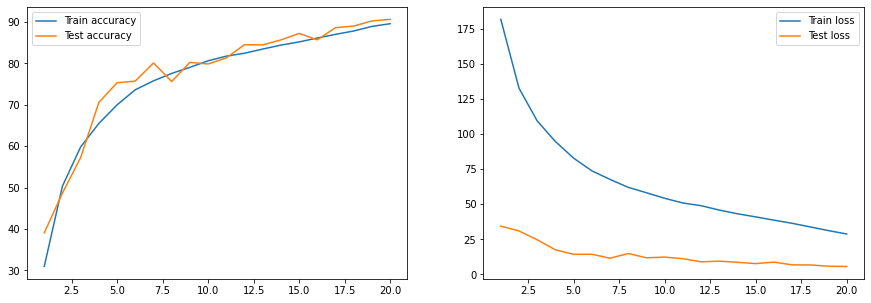

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
model.plot_accuracy()
plt.subplot(122)
model.plot_loss()
plt.savefig('images/model.png')
plt.show()

In [12]:
max(model.train_accuracy), max(model.test_accuracy)

(89.594, 90.65)

### Visualizing incorrect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


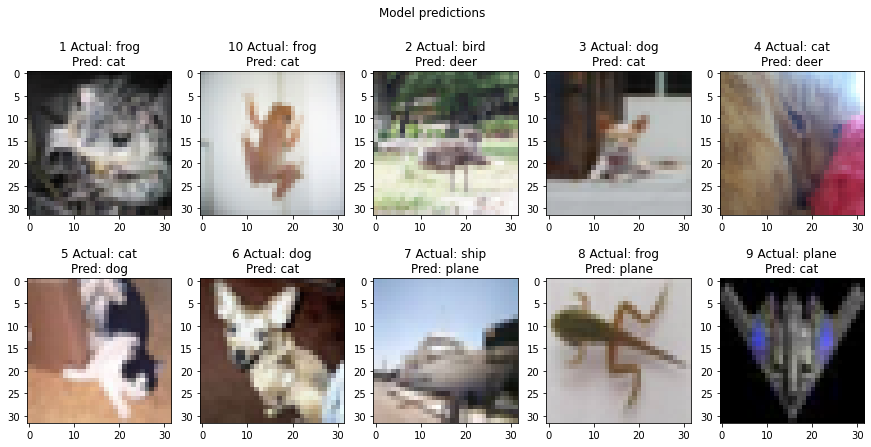

In [13]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, actual, pred = model.get_incorrect_pred(device, test_loader)
images, actual, pred = images.to('cpu'), actual.to('cpu'), pred.to('cpu')
labels = [str(indx + 1) + ' Actual: %s' % label_mapper[act.item()] + '\n' + \
    'Pred: %s' % label_mapper[pr.item()] for indx, (act, pr) in enumerate(zip(actual, pred))]
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, n_cols=5, figsize=(15, 7), img_title='Model predictions')
plt.savefig('images/incorrect_pred.png')

### Visualizing incorrect predictions using GradCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


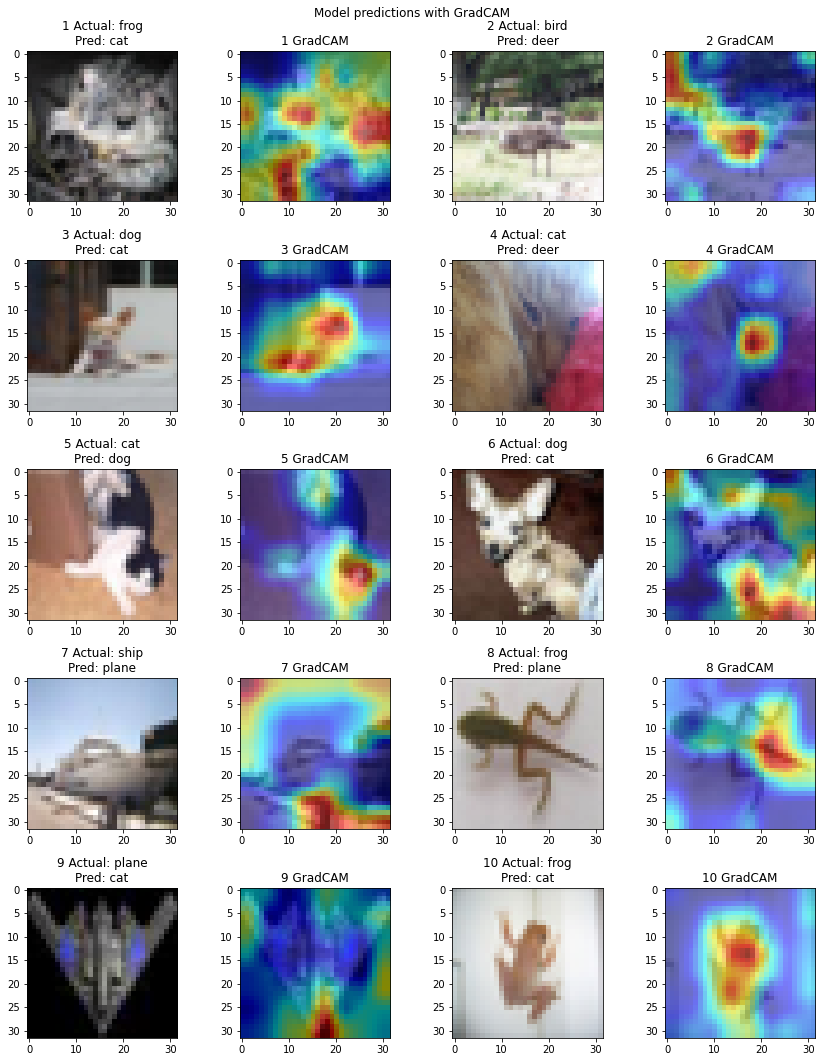

In [16]:
utils.visualize_imgs_with_gradcam(model, images, labels, pred, dataset.dt.mean, dataset.dt.std, 
    n_cols=4, figsize=(12, 15), img_title='Model predictions with GradCAM')

plt.savefig('images/incorrect_pred_with_gradcam.png')